CLASSIFYING PSYCHOLOGICAL DISORDERS VIA LARGE LANGUAGE MODELS WITH TWITTER DATA

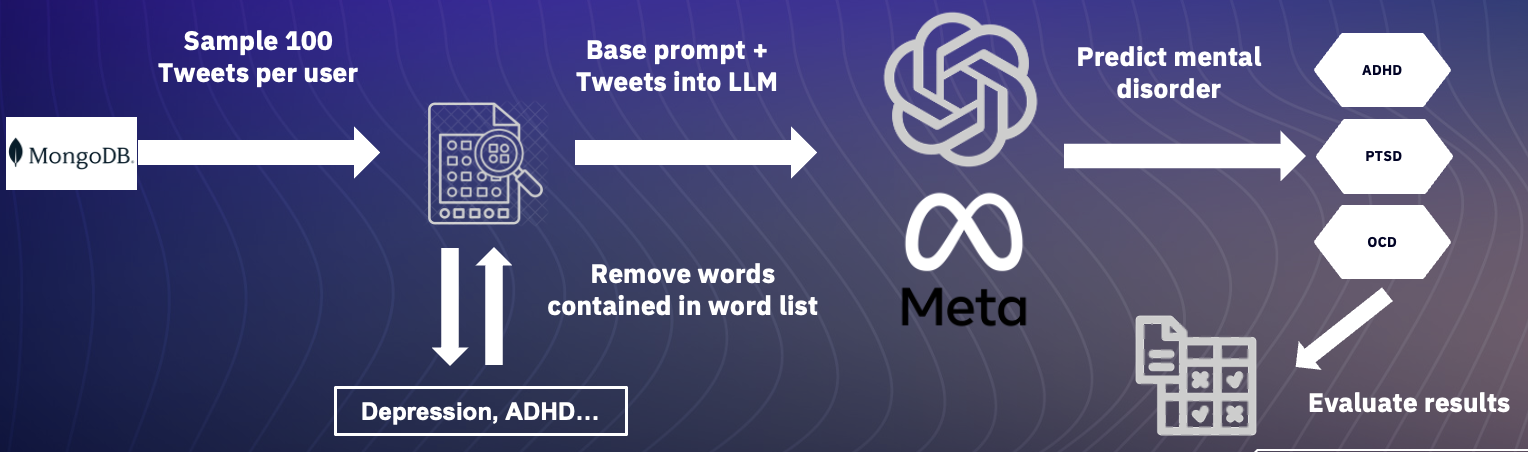

In [28]:
from IPython.display import Image
Image(filename='Explanation.png') 

For Importing all the CSV Documents from the Database we import our own created function from DBImport.py

In [29]:
# Import the DB Import function 
from DBImport import load_csv_data_to_mongodb
# Only needs to be executed once to load the data into the MongoDB
import matplotlib.pyplot as plt
# This following line should be uncommented for loading the CSV documents into the database
####load_csv_data_to_mongodb()
import os
import json
from pymongo import MongoClient
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import re
from collections import Counter
import requests
import re

OBTAIN API KEY FROM ENVIRONMENT:

PS: Make sure to save your OpenAI Key to a .env file 

In [30]:
load_dotenv()
api_key  = os.getenv("API")
client = OpenAI(api_key = api_key)
# Initialize zero as a counter for the dataframe
zero = 0

In [31]:
columns = ["Model", "User_ID", "Ground_Truth", "Predicted_Label"]
transfer = pd.DataFrame(columns=columns)

Initialize connection to MongoDB

In [32]:
client = MongoClient('mongodb://localhost:27017/')
db = client['New']
collection = db['New']

GPT 3.5 TURBO CLASSIFICATION

Database Search Function: 

In [33]:
# This function searches the database for a given disorder as keyword, groups the users by the user id and samples 45 tweets
def search_database(keyword):
    pipeline = [
    {
        '$match': {
            'class': keyword  # Filter on the class
        }
    },
    {
        '$group': {
            '_id': '$user_id',  # Group by the user ID
            'tweet': {'$push': '$tweet'}  # Collect the tweets for each user
        }
    },
    {
        '$project': {
            'sampled_tweets': {'$slice': ['$tweet', 45]}  # Select 100 entries without replacement
        }
    }
]
    result = db.New.aggregate(pipeline) # Contains all the grouped tweets by user, aggregation is already done in this part
    return result


In [34]:
def search_db(keyword, limit):
    pipeline = [
    {
        '$match': {
            'class': keyword  # Filter on the class
        }
    },
    {
        '$group': {
            '_id': '$user_id',  # Group by the user ID
            'tweet': {'$push': '$tweet'}  # Collect the tweets for each user
        }
    },
    {
        '$project': {
            'sampled_tweets': {'$slice': ['$tweet', 45]}  # Select 45 entries without replacement
        }
    },
    {
        '$limit': limit  # Limit the total number of entries to 3
    }
]
    result = db.New.aggregate(pipeline) # Contains all the grouped tweets by user, aggregation is already done in this part
    return result


Function for calling the GPT Instruct Model

In [35]:
def increase_counter(zero):
    zero +=1 
    return zero

In [36]:
def gpt_instruct(api_key, zero, result,transfer, keyword):
    # zero is a counter for the dataframe aggregation across models
    # api_key is the OpenAI needed for prompting
    # result is the fetched database query 
    # transfer is a dataframe for keeping track of our classification results 
    client = OpenAI(api_key = api_key)
    base_prompt = """
    Classify a person's psychological disorders based on text and label using these labels : [ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia]
    . What would you choose, only 1 label should be returned as output, no explanation needed. Here's an example of how the output must look like 
    Text : "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional abuse is real; this is on a societal scale."
    Labels : ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia
    This is the text : 
    """

    system_setting = "You're a classifcation bot for psychological disorders, your task is to accurately predict the psychological disorder of a user based on text"
    for document in result:
        user_prompt = "" + base_prompt
        user_prompt = user_prompt + str(document["sampled_tweets"])
        print("Start GPT")
    
        resulter = client.completions.create(
            model="gpt-3.5-turbo-instruct",
            prompt = user_prompt,
            max_tokens=50,
            temperature=0
            )
        print("Finished classifcation for user with id " + str(document["_id"]) + " the result is " +str(resulter.choices[0].text))

        transfer.loc[zero] = ["GPT3.5TurboINSTR" , document["_id"] , keyword , resulter.choices[0].text.replace("\n", "")]
        zero = increase_counter(zero)
    return transfer


Function for calling the GPT Base Model

In [37]:
def gpt_base(api_key, zero, result,transfer, keyword):
    client = OpenAI(api_key = api_key)
# Base Prompt and System Setting are needed for the GPT Classification for Multi Class
    base_prompt = """
    Classify a person's psychological disorders based on text and label using these labels : [ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia]
    . What would you choose, only 1 label should be returned as output, no explanation needed. Here's an example of how the output must look like 
    Text : "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional abuse is real; this is on a societal scale."
    Labels : ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia
    This is the text : 
    """

    system_setting = "You're a classifcation bot for psychological disorders, your task is to accurately predict the psychological disorder of a user based on text"


    for document in result:
        user_prompt = "" + base_prompt
        user_prompt = user_prompt + str(document["sampled_tweets"])
        print("Start GPT")
    
        resulter = client.chat.completions.create(
            model="gpt-3.5-turbo-0613",
            messages=[
                   {"role": "system", "content": system_setting},
                    {"role": "user", "content":user_prompt}
                    ],
            max_tokens=50,
            temperature=0
            )
    
        transfer.loc[zero] = ["GPT3.5TurboBASE" , document["_id"] , keyword , resulter.choices[0].message.content]
        zero = increase_counter(zero)

 
        print("Finished classifcation for user with id " + str(document["_id"]) + " the result is " +str(resulter.choices[0].message.content))
    return transfer

Function calling for fine tuned model:

In [38]:
def gpt_ft(api_key, zero, result,transfer, keyword):
    client = OpenAI(api_key = api_key)
# Base Prompt and System Setting are needed for the GPT Classification for Multi Class
    base_prompt = """
    Classify a person's psychological disorders based on text and label using these labels : [ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia]
    . What would you choose, only 1 label should be returned as output, no explanation needed. Here's an example of how the output must look like 
    Text : "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional abuse is real; this is on a societal scale."
    Labels : ADHD,Autism,  OCD, PTSD, Eating Disorder, Bipolar , Schizophrenia
    This is the text : 
    """

    system_setting = "You're a classifcation bot for psychological disorders, your task is to accurately predict the psychological disorder of a user based on text"


    for document in result:
        user_prompt = "" + base_prompt
        user_prompt = user_prompt + str(document["sampled_tweets"])
        print("Start GPT")
    
        resulter = client.chat.completions.create(
            model="ft:gpt-3.5-turbo-0613:nlptn::8Tas44EK",
            messages=[
                   {"role": "system", "content": system_setting},
                    {"role": "user", "content":user_prompt}
                    ],
            max_tokens=50,
            temperature=0
            )
    
        transfer.loc[zero] = ["GPT3.5FT" , document["_id"] , keyword , resulter.choices[0].message.content]
        zero = increase_counter(zero)
    

 
        print("Finished classifcation for user with id " + str(document["_id"]) + " the result is " +str(resulter.choices[0].message.content))
    return transfer

Pandas Dataframes for keeping track of model result

Multiclass Classification:

In [39]:
disorder_list = ["ADHD", "AUTISM", "BIPOLAR", "EATING DISORDER", "OCD", "PTSD", "SCHIZOPHRENIA"]


In [41]:
instruct = transfer
base = transfer
ft = transfer
for keyword in disorder_list:
    result = search_db(keyword,2)
    inst = [doc for doc in result]
    ba = inst
    fine = inst
    instruct = gpt_instruct(api_key, zero, inst,instruct, keyword)
    base = gpt_base(api_key, zero, ba, base, keyword)
    ft = gpt_ft(api_key, zero, fine, ft, keyword)
    zero += len(disorder_list)

instruct.to_csv("Multi_Classification_INSTRUCT1.csv")
base.to_csv("Multi_Classification_BASE1.csv")
ft.to_csv("Multi_Classification_FT1.csv")



Start GPT
Finished classifcation for user with id 799396 the result is 
Bipolar
Start GPT
Finished classifcation for user with id 2716031 the result is 
Schizophrenia
Start GPT
Finished classifcation for user with id 799396 the result is Text: "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional
Start GPT
Finished classifcation for user with id 2716031 the result is Text: "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional
Start GPT
Finished classifcation for user with id 799396 the result is OCD
Start GPT
Finished classifcation for user with id 2716031 the result is SCHIZOPHRENIA
Start GPT
Finished classifcation for user with id 1

If you want to test this out for yourself without having to install the database try this : 

In [49]:
instruct = transfer
base = transfer
ft = transfer
with open('DemoData.txt', 'r') as file:
    loaded_list = json.load(file)
result = loaded_list

for keyword in disorder_list:
    inst = result
    ba = inst
    fine = inst
    instruct = gpt_instruct(api_key, zero, inst,instruct, keyword)
    base = gpt_base(api_key, zero, ba, base, keyword)
    ft = gpt_ft(api_key, zero, fine, ft, keyword)
    zero += len(disorder_list)

instruct.to_csv("Multi_Classification_INSTRUCT1.csv")
base.to_csv("Multi_Classification_BASE1.csv")
ft.to_csv("Multi_Classification_FT1.csv")



Start GPT
Finished classifcation for user with id 1026962324119150592 the result is 
Eating Disorder
Start GPT
Finished classifcation for user with id 1334662148165779456 the result is 
    Schizophrenia
Start GPT
Finished classifcation for user with id 1026962324119150592 the result is Text: "@USER @USER Words that reinforce &amp; express a system of social &amp; economic oppression cause actual harm. It's just not immediate and visible, so privileged people like to say it's not the same. Courts recognize that emotional
Start GPT
Finished classifcation for user with id 1334662148165779456 the result is Label: Schizophrenia
Start GPT
Finished classifcation for user with id 1026962324119150592 the result is BIPOLAR
Start GPT
Finished classifcation for user with id 1334662148165779456 the result is SCHIZOPHRENIA
Start GPT
Finished classifcation for user with id 1026962324119150592 the result is 
Eating Disorder
Start GPT
Finished classifcation for user with id 1334662148165779456 the res

KeyboardInterrupt: 